In [24]:
from distortionMaps import d2cMapping
import mrs_aux as maux

import numpy as np
from astropy.io import fits
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')


In [19]:
# functions to fit
def straight_line(x,a,b):
    """straight line function"""
    return a*x +b

def gauss1d(x, A, mu, sigma):
    """1D Gaussian distribution function"""
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

# compute
def getSpecR(lamb,band):
    """Compute spectral resolution in 'band' at specified wavelength 'lamb' """
    bandlims = maux.MRS_bands[band]
    Rlims = maux.MRS_R[band]
    R = (Rlims[1]-Rlims[0])/(bandlims[1]-bandlims[0]) * (lamb-bandlims[0]) + Rlims[0]
    return R

In [2]:
ramps_fits = fits.open('/Users/ioannisa/Desktop/MIRFM1T00011282_1_495_SE_2011-05-31T02h15m32.fits')[0]

In [20]:
# Path to Calibration Data Products
cdpDir   = '/Users/ioannisa/Desktop/python/miri_devel/cdp_data/'

#
band = '1A'
#> detector dimensions in pixels
det_dims = (1024,1032)
# compute coordinate maps for spectral band
d2cMaps = d2cMapping(band,cdpDir)
# extract single maps
sliceMap  = d2cMaps['sliceMap']
alphaMap  = d2cMaps['alphaMap']
betaMap   = d2cMaps['betaMap']
lambdaMap = d2cMaps['lambdaMap']
nslices   = maux.MRS_nslices[band[0]]
bzero     = d2cMaps['bzero']
bdel      = d2cMaps['bdel']

bandlims = [lambdaMap[np.nonzero(lambdaMap)].min(),lambdaMap[np.nonzero(lambdaMap)].max()]
fov_lims = [alphaMap[np.nonzero(lambdaMap)].min(),alphaMap[np.nonzero(lambdaMap)].max()]

oversampling = 1.

# Construct spectral (wavelength) grid
#> initialize variables
lambcens = []
lambfwhms = []

#> loop over wavelength bins (bin width defined based on MRS spectral resolution)
done = False
lamb0 = bandlims[0]
maxlamb = bandlims[1]
while not done:
    R = getSpecR(lamb0,band)
    fwhm = lamb0 / R
    lambcen = lamb0 + (fwhm/2.)/oversampling
    if (lambcen > maxlamb-(fwhm/2.)/oversampling):
        done = True
    else:
        lamb0 = lambcen + (fwhm/2.)/oversampling

    lambcens.append(lambcen)
    lambfwhms.append(fwhm)

#> initialize variables
alphacens = []
#> loop over spaxels (spaxel size defined based on MRS PSF FWHM)
done = False
alpha0 = fov_lims[0]
maxalpha = fov_lims[1]
mrs_fwhm = maux.MRS_FWHM[band[0]]
while not done:
    alphacen = alpha0 + (mrs_fwhm/2.)/oversampling
    if (alphacen > maxalpha-(mrs_fwhm/2.)/oversampling):
        done = True
    else:
        alpha0 = alphacen + (mrs_fwhm/2.)/oversampling

    alphacens.append(alphacen)


Linear fit --
X-axis crossing at -2.84 seconds
Y-axis intercept at 1063.48 DN 

Exp fit --
X-axis crossing at -1.56 seconds
Y-axis intercept at 647.73 DN 

Linear slope from exp fit (should be same as exp fit intercept) --
X-axis crossing at -1.56 seconds
Y-axis intercept at 647.73 DN 



<IPython.core.display.Javascript object>


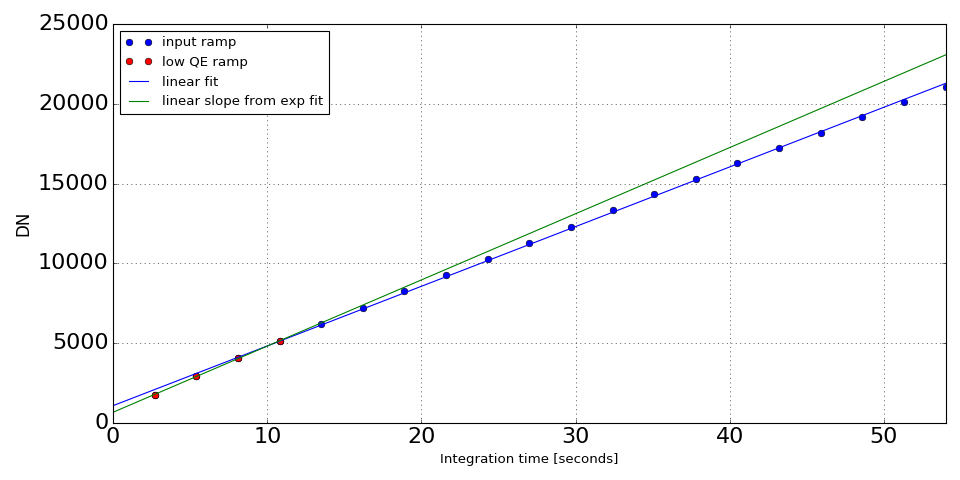

In [14]:
# using image in previous cell, select pixel to check
pixel = [465,261] # original test performed on pixel [465,261]

# define group numbers for integration ramps
group = range(1,ramps_fits.data[40:60,pixel[0],pixel[1]].shape[0]+1,1)
time  = np.array(group) * 2.7
ramp  = ramps_fits.data[40:60,pixel[1],pixel[0]]

# fitting
low_time = time[ramp<0.25*ramp[np.argmax(time)]]
low_ramp = ramp[ramp<0.25*ramp[np.argmax(time)]]
popt,pcov = curve_fit(straight_line,time,ramp)
linex = np.linspace(0,max(time))
liney = straight_line(linex,*popt)
print 'Linear fit --' 
print 'X-axis crossing at {} seconds'.format(round( -popt[1]/popt[0] ,2) )
print 'Y-axis intercept at {} DN \n'.format(round( popt[1] ,2) )

def expfit(x,a0,a,b):
    return a0 + a*(1-np.exp(-x/b) )
popt,pcov = curve_fit(expfit,low_time,low_ramp)
expfitx = np.linspace(0,max(time))
expfity = expfit(expfitx,*popt)
print 'Exp fit --'
print 'X-axis crossing at {} seconds'.format(round( -popt[2]*np.log(1 + popt[0]/popt[1]) ,2) )
print 'Y-axis intercept at {} DN \n'.format(round( popt[0] ,2) )

linearslopex = np.linspace(0,max(time))
linearslopey = straight_line(linearslopex,popt[1]/popt[2],popt[0])
print 'Linear slope from exp fit (should be same as exp fit intercept) --'
print 'X-axis crossing at {} seconds'.format(round(-popt[0]/(popt[1]/popt[2]),2) )
print 'Y-axis intercept at {} DN \n'.format(round( popt[0] ,2) )

# plot--------------------------------------
fig = plt.figure(figsize=(12,6))

# plot input and output ramps of the first integration
plt.plot(time, ramp, 'bo', label='input ramp')
plt.plot(low_time, low_ramp, 'ro', label='low QE ramp')
plt.plot(linex,liney,label='linear fit')
# plt.plot(expfitx,expfity,label='exp fit')
plt.plot(linearslopex,linearslopey,label='linear slope from exp fit')
# plt.vlines([54,108,162],0,25000)
plt.xlabel('Integration time [seconds]')
plt.ylabel('DN',fontsize=15)
plt.xlim(0,max(time))
# plt.ylim(0,25000) 
plt.legend(prop={'size':12}, loc=0)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()
plt.grid()

<IPython.core.display.Javascript object>


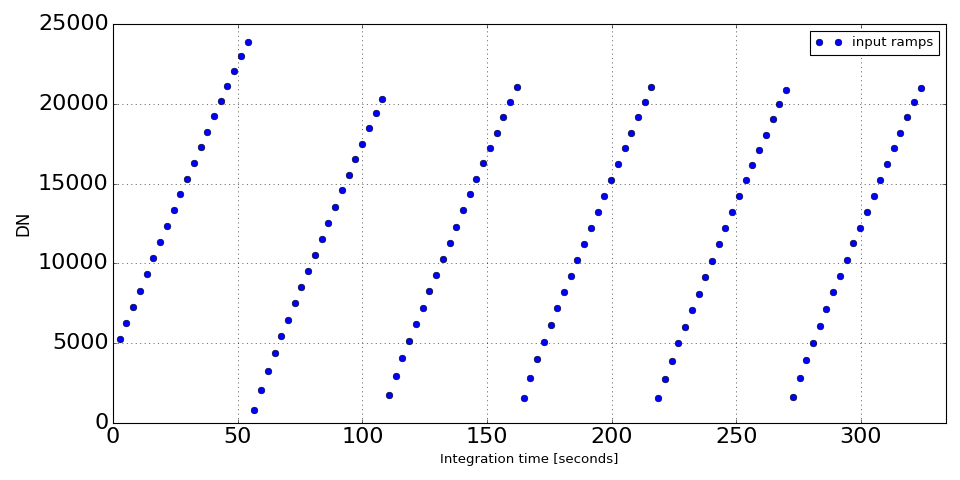

In [36]:
# using image in previous cell, select pixel to check
pixel = [465,261]

# define group numbers for integration ramps
group = range(1,ramps_fits.data[:,pixel[0],pixel[1]].shape[0]+1,1)
time  = np.array(group) * 2.7
ramps  = ramps_fits.data[:,pixel[1],pixel[0]]

# plot--------------------------------------
fig = plt.figure(figsize=(12,6))

# plot input and output ramps of the first integration
plt.plot(time, ramps,'bo',label='input ramps')
plt.xlabel('Integration time [seconds]')
plt.ylabel('DN',fontsize=15)
plt.xlim(0,max(time)+10)
plt.ylim(0)
plt.legend(prop={'size':12}, loc=0)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()
plt.grid()

In [23]:
pixi,pixj = np.where((sliceMap != 0) & (sliceMap<200))
pixi = np.delete(pixi, np.where(pixi > 1020))
pixj = np.delete(pixj, np.where(pixi > 1020))

intercepts,intercepts_img = [],np.full(det_dims,np.nan)
for i in xrange(len(pixi)):
    group = range(1,ramps_fits.data[40:60,pixi[i],pixj[i]].shape[0]+1,1)
    time  = np.array(group) * 2.7
    ramp  = ramps_fits.data[40:60,pixi[i],pixj[i]]
    
    # fitting
    low_time = time[ramp<0.25*ramp[np.argmax(time)]]
    low_ramp = ramp[ramp<0.25*ramp[np.argmax(time)]]
    
    if len(low_time)<3:
        continue
    else:
        popt,pcov = curve_fit(expfit,low_time,low_ramp)
    
    intercepts.append(popt[0])
    intercepts_img[pixi[i],pixj[i]] = popt[0]


/Users/ioannisa/anaconda2/envs/miricle/lib/python2.7/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/ioannisa/anaconda2/envs/miricle/lib/python2.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: overflow encountered in exp
/Users/ioannisa/anaconda2/envs/miricle/lib/python2.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: overflow encountered in multiply


<IPython.core.display.Javascript object>


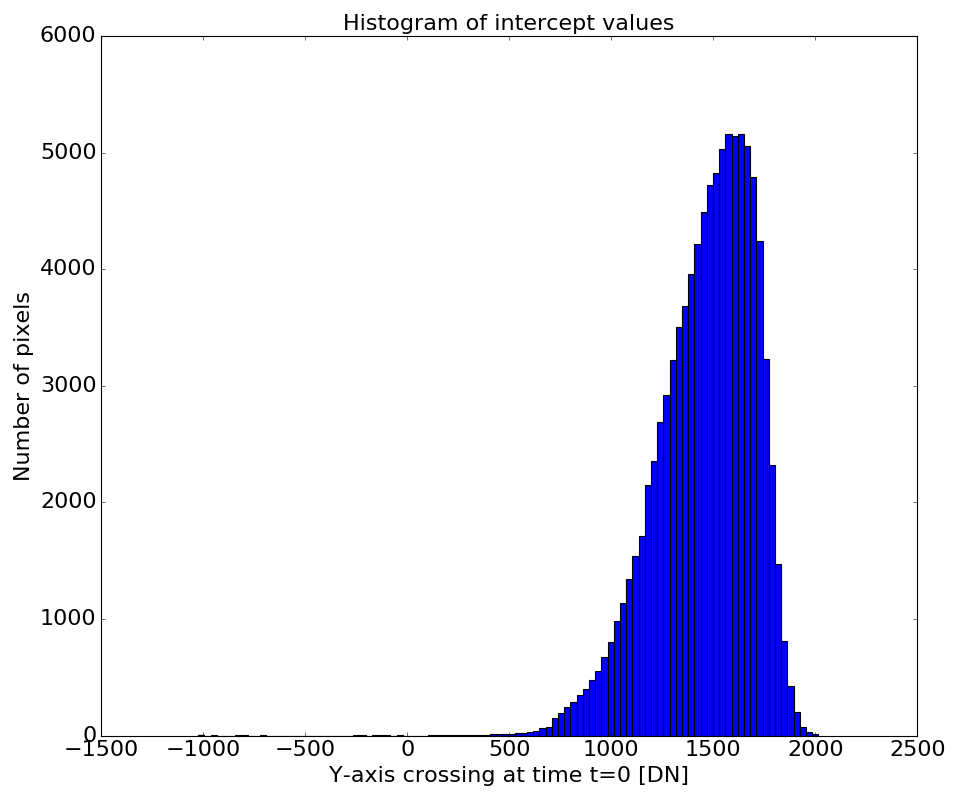

In [25]:
plt.figure(figsize=(12,10))
plt.hist(np.array(intercepts),bins=100)
plt.tick_params(axis='both',labelsize=20)
plt.title('Histogram of intercept values',fontsize=20)
plt.xlabel('Y-axis crossing at time t=0 [DN]',fontsize=20)
plt.ylabel('Number of pixels',fontsize=20)
plt.tight_layout()


<IPython.core.display.Javascript object>


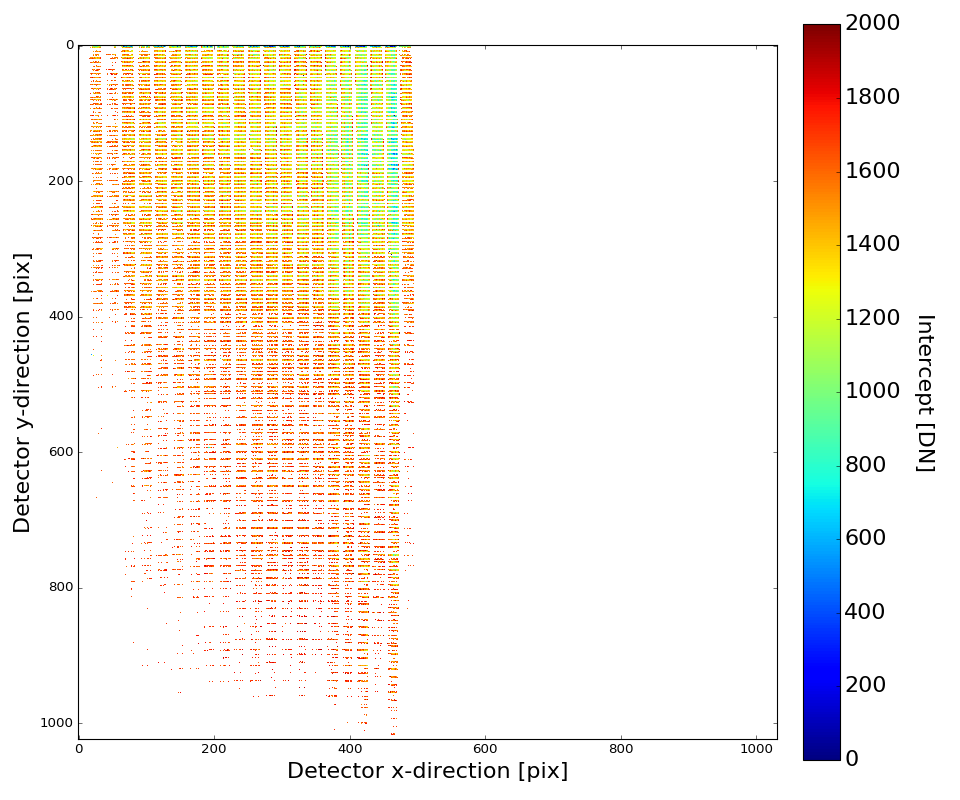

In [27]:
plt.figure(figsize=(12,10))
sc = plt.imshow(intercepts_img,interpolation='None',vmin=0,vmax=2000)
# plt.plot(np.arange(len(intercepts_img[:,465]))[~np.isnan(intercepts_img[:,465])],intercepts_img[:,465][~np.isnan(intercepts_img[:,465])])
cbar = plt.colorbar(sc,pad = 0.03)
cbar.ax.tick_params(labelsize=20)
cbar.set_label(r'Intercept [DN]', labelpad=30,rotation=270,fontsize=20)
plt.xlabel(r'Detector x-direction [pix]',fontsize=20)
plt.ylabel(r'Detector y-direction [pix]',fontsize=20)
plt.tight_layout()

<IPython.core.display.Javascript object>


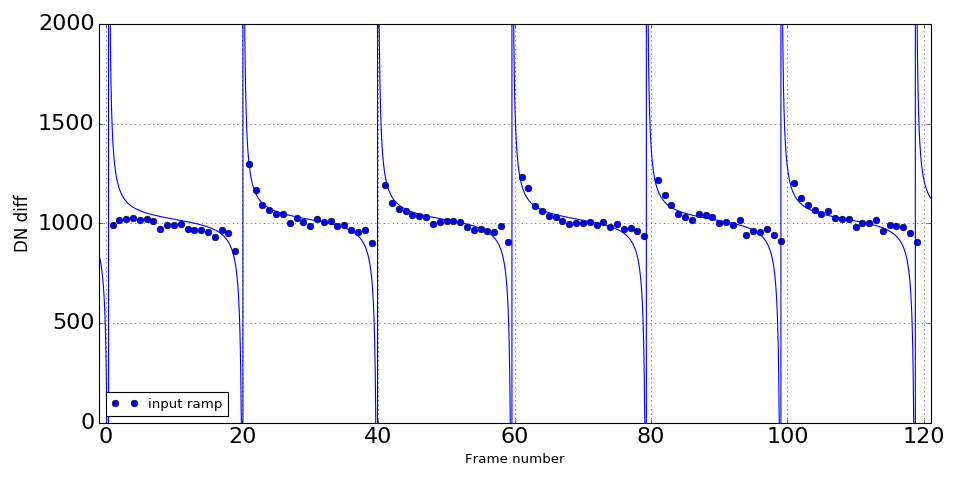

In [30]:
# Fit tangent function to 1st order difference
testx = np.linspace(-2*np.pi,5*np.pi,10000)
testy = -np.tan(testx)+1

group = range(1,ramps_fits.data[:,pixel[0],pixel[1]].shape[0]+1,1)

# plot--------------------------------------
fig = plt.figure(figsize=(12,6))

# plot input and output ramps of the first integration
plt.plot(group[:-1], np.diff(ramps_fits.data[:,pixel[1],pixel[0]]), 'bo', label='input ramp')
plt.plot(testx*6.28 +30,testy*40 + 980)
plt.xlabel('Frame number')
plt.ylabel('DN diff',fontsize=15)
plt.xlim(-1,max(group)+1)
plt.ylim(0,2000)
plt.legend(prop={'size':12}, loc=0)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()
plt.grid()

<IPython.core.display.Javascript object>


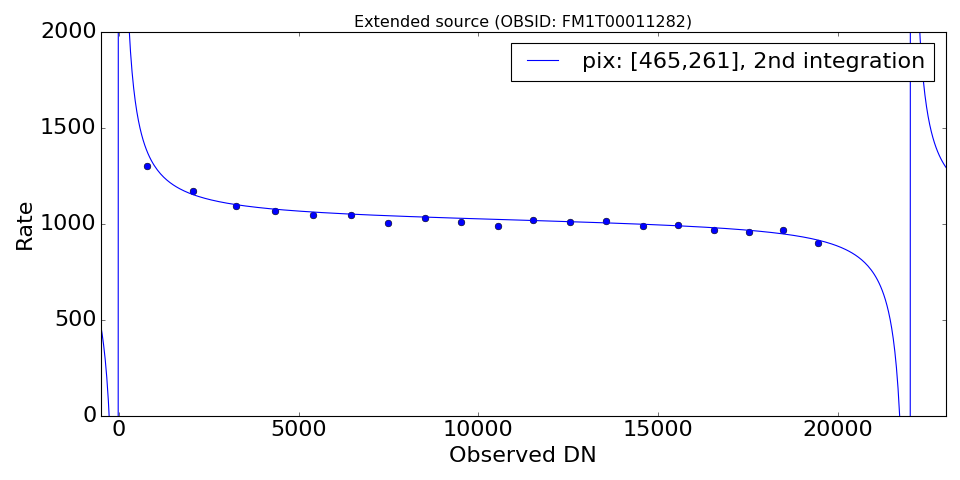

In [33]:
testx = np.linspace(-np.pi,np.pi,1000)
testy = -np.tan(testx)+1

plt.figure(figsize=(12,6))
for i in range(20,39):
    plt.plot(ramps_fits.data[:,pixel[1],pixel[0]][i],ramps_fits.data[:,pixel[1],pixel[0]][i+1]-ramps_fits.data[:,pixel[1],pixel[0]][i],'bo' )
plt.plot(testx*7000 +11000,testy*40 + 980,label='pix: [465,261], 2nd integration')
plt.xlim(-500,23000)
plt.ylim(0,2000)
plt.title('Extended source (OBSID: FM1T00011282)')
plt.xlabel('Observed DN',fontsize=20)
plt.ylabel('Rate',fontsize=20)
plt.tick_params(axis='both',labelsize=20)
plt.legend(loc='upper right',fontsize=20)
plt.tight_layout()